In [1]:
import os
import warnings

warnings.filterwarnings('ignore')
train_data_path = '/kaggle/input/noisyastrogeo/new_noise2_32k'
# '/kaggle/input/astrogeonoisy96k/noise_96k'
val_data_path = '/kaggle/input/astrogeo512x512/data_512x512_abs'

In [2]:
import torch.nn as nn
import torch
from torchvision import datasets, transforms
import torch.optim as optim
from tqdm import tqdm

class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(64*16*16, 128)
        self.fc2 = nn.Linear(128, 4)

        self.relu = nn.ReLU()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)
    
    def forward(self, image: torch.Tensor) -> torch.Tensor:
        image = self.conv1(image)
        image = self.relu(image)
        image = self.pool(image)
        image = self.conv2(image)
        image = self.relu(image)
        image = self.pool(image)
        image = self.conv3(image)
        image = self.relu(image)
        image = self.pool(image)
        image = image.view(-1, 64*16*16)
        image = self.fc1(image)
        image = self.relu(image)
        image = self.dropout(image)
        image = self.fc2(image)
        return image

In [3]:
num_epochs = 30
batch_size = 256
learning_rate = 1e-4
weight_decay = 1e-5
train_test_ratio = 0.8

In [4]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=(0, 360), translate=(0.1, 0.3), scale=(0.8, 1.2)), #degrees=(0, 180)
#     transforms.CenterCrop((64, 64)),
#     transforms.Resize(size=(128, 128)),
#     transforms.AutoAugment(),
    transforms.RandAugment(num_ops=3),
    transforms.ToTensor()]
)
data = datasets.ImageFolder(train_data_path, transform=transform)

train_size = int(train_test_ratio * len(data))
test_size = len(data) - train_size
train, test = torch.utils.data.random_split(data, [train_size, test_size])
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=4)

model = CNN()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()
model.train()

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [5]:
AccTest, LossTest = [], []
y_test, predictions = [], []
def test(flag=False):
    with torch.no_grad():
        correct, total = 0, 0
        test_loss = 0.0
        for images, labels in tqdm(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            if flag:
                y_test.extend(labels.cpu().numpy())
                predictions.extend(predicted.cpu().numpy())
        acc = 100 * correct / total
        test_loss = test_loss / len(testloader.dataset)
        AccTest.append(acc)
        LossTest.append(test_loss)
        print(f'Epoch: {epoch+1} \tTest Loss: {test_loss:.6f} \tTest Acc: {acc:.3f}%')

In [6]:
AccTrain, LossTrain = [], []

for epoch in range(num_epochs):
    train_loss = 0.0
    correct, total = 0, 0
    for data, target in tqdm(trainloader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        train_loss += loss.item() * data.size(0)
    if epoch + 1 == num_epochs:
        test(True)
    else:
        test()
    train_loss = train_loss / len(trainloader.dataset)
    acc = 100 * correct / total
    AccTrain.append(acc)
    LossTrain.append(train_loss)
    print(f'Epoch: {epoch+1} \tTrain Loss: {train_loss:.6f} \tTrain Acc: {acc:.3f}%')


100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Epoch: 1 	Test Loss: 1.295698 	Test Acc: 37.422%
Epoch: 1 	Train Loss: 1.356215 	Train Acc: 32.332%


100%|██████████| 25/25 [00:25<00:00,  1.02s/it]


Epoch: 2 	Test Loss: 1.090694 	Test Acc: 48.344%
Epoch: 2 	Train Loss: 1.204635 	Train Acc: 41.605%


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch: 3 	Test Loss: 0.930549 	Test Acc: 53.078%
Epoch: 3 	Train Loss: 0.992913 	Train Acc: 50.934%


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch: 4 	Test Loss: 0.861254 	Test Acc: 57.094%
Epoch: 4 	Train Loss: 0.883925 	Train Acc: 55.461%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 5 	Test Loss: 0.817537 	Test Acc: 58.844%
Epoch: 5 	Train Loss: 0.844577 	Train Acc: 57.766%


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch: 6 	Test Loss: 0.800909 	Test Acc: 60.406%
Epoch: 6 	Train Loss: 0.819100 	Train Acc: 58.762%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 7 	Test Loss: 0.787253 	Test Acc: 61.734%
Epoch: 7 	Train Loss: 0.803114 	Train Acc: 59.793%


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch: 8 	Test Loss: 0.778470 	Test Acc: 61.188%
Epoch: 8 	Train Loss: 0.789765 	Train Acc: 60.527%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 9 	Test Loss: 0.754410 	Test Acc: 62.062%
Epoch: 9 	Train Loss: 0.774259 	Train Acc: 61.309%


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch: 10 	Test Loss: 0.752545 	Test Acc: 62.641%
Epoch: 10 	Train Loss: 0.763127 	Train Acc: 61.781%


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch: 11 	Test Loss: 0.732599 	Test Acc: 63.672%
Epoch: 11 	Train Loss: 0.751489 	Train Acc: 62.699%


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch: 12 	Test Loss: 0.728978 	Test Acc: 63.234%
Epoch: 12 	Train Loss: 0.743357 	Train Acc: 63.430%


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch: 13 	Test Loss: 0.709995 	Test Acc: 65.047%
Epoch: 13 	Train Loss: 0.733508 	Train Acc: 63.781%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 14 	Test Loss: 0.712546 	Test Acc: 65.109%
Epoch: 14 	Train Loss: 0.732118 	Train Acc: 64.504%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 15 	Test Loss: 0.715104 	Test Acc: 65.578%
Epoch: 15 	Train Loss: 0.706701 	Train Acc: 65.426%


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch: 16 	Test Loss: 0.694957 	Test Acc: 65.609%
Epoch: 16 	Train Loss: 0.703113 	Train Acc: 65.840%


100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch: 17 	Test Loss: 0.678312 	Test Acc: 67.094%
Epoch: 17 	Train Loss: 0.688953 	Train Acc: 66.426%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 18 	Test Loss: 0.668732 	Test Acc: 67.594%
Epoch: 18 	Train Loss: 0.681708 	Train Acc: 67.137%


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch: 19 	Test Loss: 0.672460 	Test Acc: 67.219%
Epoch: 19 	Train Loss: 0.671032 	Train Acc: 67.727%


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch: 20 	Test Loss: 0.644238 	Test Acc: 69.516%
Epoch: 20 	Train Loss: 0.652799 	Train Acc: 68.863%


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch: 21 	Test Loss: 0.638748 	Test Acc: 69.562%
Epoch: 21 	Train Loss: 0.652223 	Train Acc: 68.305%


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch: 22 	Test Loss: 0.636203 	Test Acc: 69.375%
Epoch: 22 	Train Loss: 0.647015 	Train Acc: 68.715%


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch: 23 	Test Loss: 0.629082 	Test Acc: 69.062%
Epoch: 23 	Train Loss: 0.634919 	Train Acc: 69.504%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 24 	Test Loss: 0.625999 	Test Acc: 71.516%
Epoch: 24 	Train Loss: 0.630293 	Train Acc: 70.297%


100%|██████████| 25/25 [00:25<00:00,  1.01s/it]


Epoch: 25 	Test Loss: 0.608580 	Test Acc: 71.766%
Epoch: 25 	Train Loss: 0.618113 	Train Acc: 70.891%


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch: 26 	Test Loss: 0.599000 	Test Acc: 71.750%
Epoch: 26 	Train Loss: 0.610498 	Train Acc: 71.355%


100%|██████████| 25/25 [00:25<00:00,  1.00s/it]


Epoch: 27 	Test Loss: 0.589094 	Test Acc: 72.484%
Epoch: 27 	Train Loss: 0.599065 	Train Acc: 72.102%


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


Epoch: 28 	Test Loss: 0.585580 	Test Acc: 72.922%
Epoch: 28 	Train Loss: 0.599987 	Train Acc: 72.301%


100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch: 29 	Test Loss: 0.596178 	Test Acc: 72.625%
Epoch: 29 	Train Loss: 0.591243 	Train Acc: 72.672%


100%|██████████| 25/25 [00:24<00:00,  1.00it/s]

Epoch: 30 	Test Loss: 0.587204 	Test Acc: 71.578%
Epoch: 30 	Train Loss: 0.582903 	Train Acc: 73.184%


In [7]:
torch.save(model.state_dict(), 'noise.pth')

Precision: 72.283 %
Recall: 71.622 %
F1 Score: 71.951 %
F1 Macro Score: 71.541 %
F1 Weighted Score: 71.497 %


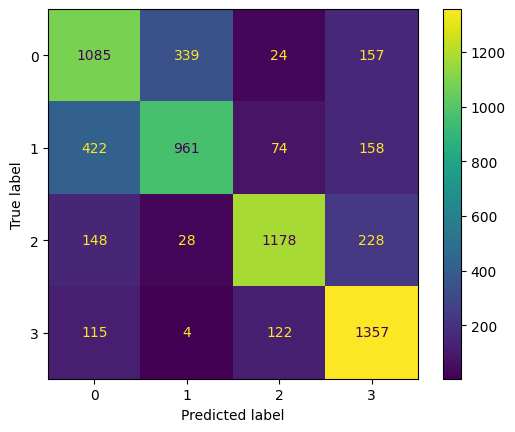

In [8]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.savefig(f'ConfMatrix_noise.png', dpi=500)

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
    
f1 = 2 * precision * recall / (precision + recall)
f1_macro = f1_score(y_test, predictions, average='macro')
f1_weighted = f1_score(y_test, predictions, average='weighted')
print(f'Precision: {100 * precision:.3f} %')
print(f'Recall: {100 * recall:.3f} %')
print(f'F1 Score: {100 * f1:.3f} %')
print(f'F1 Macro Score: {100 * f1_macro:.3f} %')
print(f'F1 Weighted Score: {100 * f1_weighted:.3f} %')

In [9]:
import os
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode

class AstrogeoDataset(Dataset):
    def __init__(self, dir: str, transform=None) -> None:
        self.transform = transform
        self.images = os.listdir(dir)
        self.dir = dir

    def __getitem__(self, index: int) -> tuple:
        image = read_image(
            f'{self.dir}/{self.images[index]}',
            mode=ImageReadMode.RGB
        )
        file_name = self.images[index]
        if self.transform is not None:
            image = self.transform(image)
        return (file_name, image)

    def __len__(self) -> int:
        return len(self.images)

In [10]:
import json
import pandas as pd

transform = transforms.Compose([
    transforms.ToPILImage(), transforms.Resize((128, 128)),
    transforms.Grayscale(), transforms.ToTensor()]
)
val = AstrogeoDataset(val_data_path, transform=transform)
valloader = torch.utils.data.DataLoader(
    val, batch_size=batch_size, shuffle=True, num_workers=4
)

model.eval()
val_preds = {}
with torch.no_grad():
    for file_names, images in tqdm(valloader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        val_preds.update(dict(zip(file_names, predicted.cpu().tolist())))
        
with open('predicts.json', 'w') as f:
    json.dump(val_preds, f)

s1 = pd.Series(val_preds.keys())
s2 = pd.Series(val_preds.values())
df = pd.concat([s1, s2], axis=1)
df = df.rename(columns={0: 'file_name', 1: 'predicted_class'})
df.to_csv('classification.csv')

100%|██████████| 350/350 [05:32<00:00,  1.05it/s]


{0: 26793, 1: 26, 2: 62675, 3: 91}


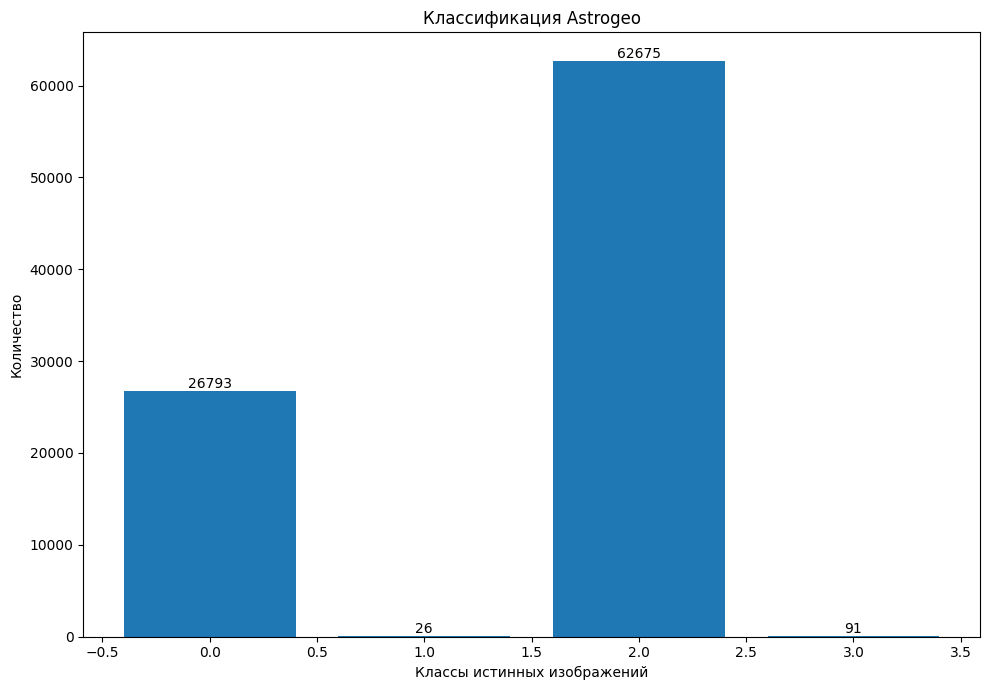

In [11]:
from collections import Counter

labels = [
    'Одиночный источник', 'Двойной источник',
    'Источник с джетом', 'Источник с двойным джетом'
]
res = dict(Counter(val_preds.values()))
res = {k: v for k, v in sorted(res.items())}
print(res)
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
bar = ax.bar(res.keys(), res.values())
ax.bar_label(bar, labels=res.values())
ax.set_xlabel('Классы истинных изображений')
ax.set_ylabel('Количество')
ax.set_title('Классификация Astrogeo')
fig.tight_layout()
plt.savefig('histogram.png', dpi=500)

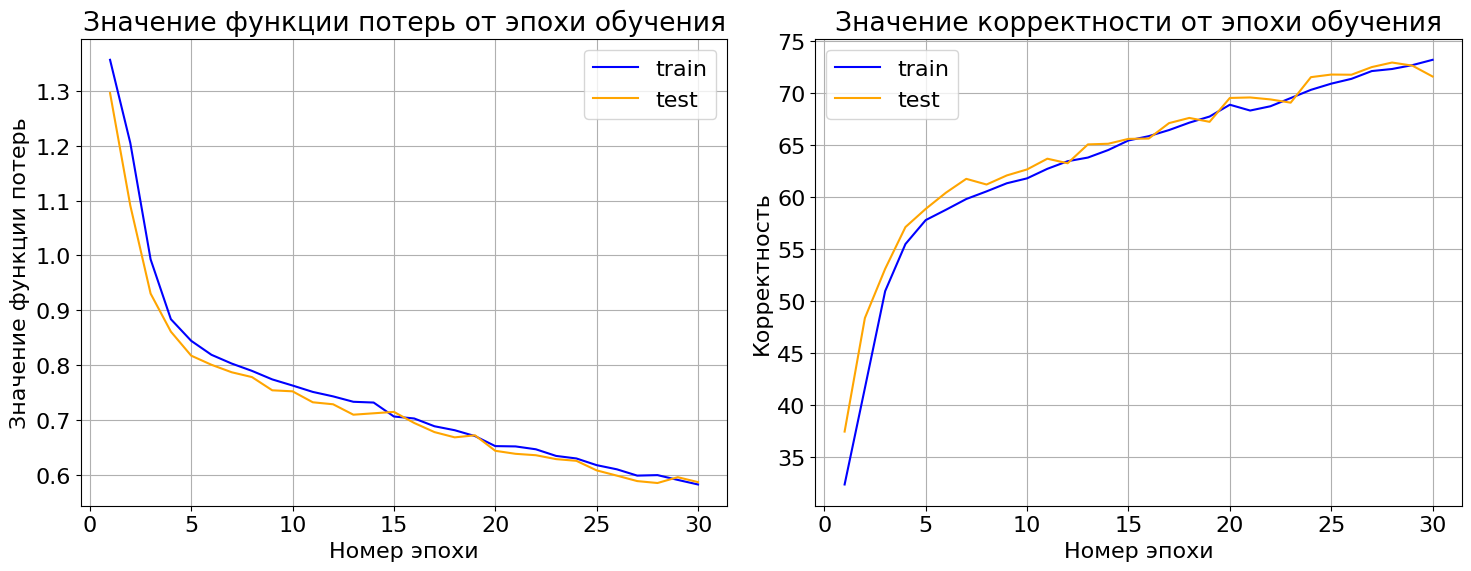

In [12]:
import numpy as np

plt.rcParams.update({'font.size': 16})
epochs = np.arange(1, num_epochs + 1)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].plot(epochs, LossTrain, label='train', color='blue')
axes[0].plot(epochs, LossTest, label='test', color='orange')
axes[0].set_title('Значение функции потерь от эпохи обучения')
axes[0].set_xlabel('Номер эпохи')
axes[0].set_ylabel('Значение функции потерь')
axes[0].grid()
axes[0].legend()

axes[1].plot(epochs, AccTrain, label='train', color='blue')
axes[1].plot(epochs, AccTest, label='test', color='orange')
axes[1].set_title('Значение корректности от эпохи обучения')
axes[1].set_ylabel('Корректность')
axes[1].set_xlabel('Номер эпохи')
axes[1].grid()
axes[1].legend()
plt.tight_layout()
plt.savefig('train.png', dpi=500)

In [13]:
val_data_path2 = '/kaggle/input/lisakovonelove/val'
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()]
)
val = datasets.ImageFolder(val_data_path2, transform=transform)
valloader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True, num_workers=4)
AccTest, LossTest = [], []
y_test, predictions = [], []

with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    for images, labels in tqdm(valloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        test_loss += loss.item() * data.size(0)
        y_test.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())
    acc = 100 * correct / total
    test_loss = test_loss / len(testloader.dataset)
    AccTest.append(acc)
    LossTest.append(test_loss)
    print(f'Epoch: {epoch+1} \tVal Loss: {test_loss:.6f} \tVal Acc: {acc:.3f}%')

100%|██████████| 3/3 [00:03<00:00,  1.19s/it]

Epoch: 30 	Val Loss: 0.175455 	Val Acc: 46.284%


Precision: 48.238 %
Recall: 27.569 %
F1 Score: 35.086 %
F1 Macro Score: 24.861 %
F1 Weighted Score: 41.059 %


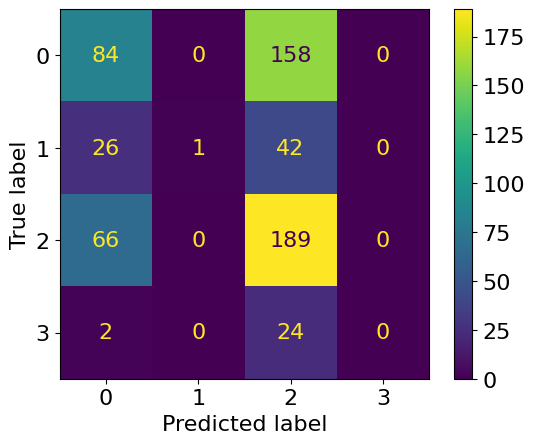

In [14]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, predictions)
ConfusionMatrixDisplay(cm).plot()
plt.savefig(f'ConfMatrix_noise.png', dpi=500)

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
    
f1 = 2 * precision * recall / (precision + recall)
f1_macro = f1_score(y_test, predictions, average='macro')
f1_weighted = f1_score(y_test, predictions, average='weighted')
print(f'Precision: {100 * precision:.3f} %')
print(f'Recall: {100 * recall:.3f} %')
print(f'F1 Score: {100 * f1:.3f} %')
print(f'F1 Macro Score: {100 * f1_macro:.3f} %')
print(f'F1 Weighted Score: {100 * f1_weighted:.3f} %')